# Deep Learning Big Project : Implement Steps

1. Part1: DataLoader
2. Part2: Data Visualization 
3. Part3: Build Model 
4. Part4: Save and Load Model 


# Table of contents
1. Imports 
2. Helper Functions
3. Preparing the dataset -- Data Visualization 
4. Data Visualization
5. Modeling 

# 1. Imports

In [1]:
#Import Library 

# Machine Learning and Data Science Imports 
import pandas as pd
import numpy as np
import scipy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Built In Imports
from datetime import datetime
import tqdm

# Visualization Imports
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#Evaluate Import

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# 2. Helper Function 

1. Calculate accuracy : cal_acc()
2. Validation loss and accuracy : validation()
3. Plot a loss graph : plot_loss
4. Plot an accuracy graph : plot_accuracy

In [2]:
def cal_acc(outputs,labels):
    pred_labels=torch.max(outputs,1)[1]
    equality = torch.eq(pred_labels,labels).float()
    accuracy = torch.mean(equality)
    return accuracy


def validation(model, validation_loader, criterion):
    validation_loss = 0
    accuracy = 0
    output_list=[]
    labels_list=[]
    
    for images, labels in validation_loader:
        labels_list.append(labels)        
        outputs = model(images)
        output_list.append(torch.max(outputs,1)[1])
        validation_loss += criterion(outputs,torch.flatten(labels.long())).item()
        accuracy += cal_acc(outputs,labels)
        
        accuracy += cal_acc(outputs,labels)

    val_loss= validation_loss/len(validation_loader)
    val_acc= accuracy/len(validation_loader)
    return val_loss,val_acc,output_list,labels_list

def plot_loss(model):
    plt.plot(model.history['train_loss'], label='Loss (training data)')
    plt.plot(model.history['validation_loss'], label='Loss (validation data)')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper left")
    plt.show()
    
    return None

def plot_accuracy(model):
    plt.plot(model.history['train_accuracy'], label='Accuracy (training data)')
    plt.plot(model.history['validation_accuracy'], label='Accuracy (validation data)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc="upper left")
    plt.show()
    return None

# def binary_acc(y_pred, y_test):
#     y_pred_tag = torch.round(torch.sigmoid(y_pred))
#     correct_results_sum = (y_pred_tag == y_test).sum().float()
#     acc = correct_results_sum/y_test.shape[0]
#     acc = torch.round(acc * 100)
    
#     return acc

def evaluate(y_test, y_pred):
    result={}
      # Calculate AUC
    result['AUC']=roc_auc_score(y_test,y_pred)
    #   print("AUC is: ", roc_auc_score(y_test,y_pred) )
      # recall and precision
    result['report']=classification_report(y_test, y_pred)
    #   print(classification_report(y_test, y_pred))
      # confusion matrix
    result['ConMatrix']=confusion_matrix(y_test, y_pred)
    #   print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

      # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
      # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    ax.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate or (1 - Specifity)')
    ax.set_ylabel('True Positive Rate or (Sensitivity)')
    ax.set_title('Receiver Operating Characteristic')


    return result,fig

# Part1: DataLoader 

1. Set up a train class
2. Set up a validation Class
3. Set up a test class

In [3]:
#1. train 
class train(Dataset):
    def __init__(self,path):
        self.dataset_paths=path
        
        self.price_features = ["High", "Low", "Close"]
        self.CCI_features = ["CCI5", "CCI10", "CCI20"]
        self.MACD_features = ["MACD", "MACDsignal", "MACDhist"]
        
        self.data=pd.read_csv(self.dataset_paths)
        self.train=self.data[:int(0.95*len(self.data))]
    
        self.ndays1=5
        self.ndays2=10
        self.ndays3=20
        
        self.macd, self.signal, self.macd_hist = self.get_macd_indicators(self.train)
        self.train_date, self.train_images, self.train_labels=self.get_features()
        
    def get_CCI(self,data, ndays):
        typical_price = (data['High'] + data['Low'] + data['Close']) / 3 
        moving_avg = typical_price.rolling(ndays).mean()
        mean_deviation = typical_price.rolling(ndays).apply(lambda x: pd.Series(x).mad())
        CCI = (typical_price - moving_avg) / (0.015 * mean_deviation) 
        return CCI
    
    def get_macd_indicators(self,data):
        moving_avg26 = data['Close'].rolling(26).mean()
        exp_moving_avg12 = data['Close'].ewm(span=12, adjust=False).mean()
        macd = exp_moving_avg12 - moving_avg26
        signal = macd.rolling(9).mean()
        macd_hist = macd - signal
        return macd, signal, macd_hist
    
    def get_train_images(self,train_features):
        train_images = []
        for i in range(len(train_features)-9):
            image1 = train_features[self.price_features][i:i+10].T
            image2 = train_features[self.CCI_features][i:i+10].T
            image3 = train_features[self.MACD_features][i:i+10].T
            #image4 = train_features[return_features][i:i+10].T


            image_total1 = np.append(arr=image1.values.reshape((3, 10, 1)), values=image2.values.reshape((3, 10, 1)), axis=2)
            image_total2 = np.append(arr=image_total1, values=image3.values.reshape((3, 10, 1)), axis=2)
            #image_total3 = np.append(arr=image_total2, values=image4.values.reshape((3, 10, 1)), axis=2)
            
            #print('image_total1: ', image_total1)
            #print('image_total2: ', image_total2)
            train_images.append(torch.Tensor(image_total2))
            #print('torch.Tensor(image_total2)', torch.Tensor(image_total2).shape)

        return train_images
    
    def plot_CCI(self):
        fig, ax = plt.subplots()
        ax.plot(self.get_CCI(self.train, self.ndays1)[:100])
        plt.show()
        return None
    
    def plot_macd(self):
        fig,ax=plt.subplots()
        ax.plot(self.macd)
        ax.set_title("MACD Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD")
        plt.show()
        return None
        
    def plot_signal(self):
        fig,ax=plt.subplots()
        ax.plot(self.signal)
        ax.set_title("MACD signal Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD signal")
        plt.show()
        return None
        
    def plot_macd_hist(self):
        fig,ax=plt.subplots()
        ax.plot(self.macd_hist)
        ax.set_title("MACD histogram Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD histogram")
        plt.show()
        return None
        
    def __len__(self):
        return len(self.train_images)
    
    def get_features(self):
        train_features = self.train.copy()
        train_features["CCI5"] = self.get_CCI(train_features, 5)
        train_features["CCI10"] = self.get_CCI(train_features, 10)
        train_features["CCI20"] = self.get_CCI(train_features, 20)

        train_features["MACD"], train_features["MACDsignal"], train_features["MACDhist"] = self.get_macd_indicators(train_features)

        #Calculate future returns features
        close_next = train_features["Close"].shift(-1)
        returns = (close_next - train_features["Close"]) / (train_features["Close"])

        #convert futures return to boolean
        train_features["y"] = np.sign(returns).replace(-1, 0)

        #train_features["returns1"] = returns.shift(1)
        #train_features["returns2"] = returns.shift(2)
        #train_features["returns3"] = returns.shift(3)

        train_features = train_features.dropna()
        train_date = train_features["Date"]
        train_labels = train_features["y"]
        train_features = train_features[self.price_features + self.CCI_features + self.MACD_features]

        #print('train_features: ', train_features)
        #convert train_features and train_labels to train_images in tf format
        train_images = torch.stack(tuple(self.get_train_images(train_features)),dim=0)
        train_labels = torch.stack(tuple([torch.Tensor([i]) for i in train_labels[9:]]),dim=0)
        
        #print('train_images.size())',train_images.size())
        #print('train_images',train_images)
        #print('train_labels[9:1]',train_labels[9:].shape)
        #print('train_labels',train_labels)
#         train_labels = torch.stack(torch.Tensor(train_labels[9:]),dim=0)
#         train_images = self.get_train_images(train_features)
#         train_labels = train_labels[9:]
       


        return train_date[9:], train_images, train_labels
    
    def __getitem__(self,index):
#         print(index)
        
#         print(self.train_images[0])
        return self.train_images[index],self.train_labels[index]



In [4]:
# 2. Val

class val(Dataset):
    def __init__(self,path):
        self.dataset_paths=path
        
        self.price_features = ["High", "Low", "Close"]
        self.CCI_features = ["CCI5", "CCI10", "CCI20"]
        self.MACD_features = ["MACD", "MACDsignal", "MACDhist"]
        
        self.data=pd.read_csv(self.dataset_paths)
        self.train=self.data[int(0.95*len(self.data)):]
    
        self.ndays1=5
        self.ndays2=10
        self.ndays3=20
        
        self.macd, self.signal, self.macd_hist = self.get_macd_indicators(self.train)
        self.train_date, self.train_images, self.train_labels=self.get_features()
#         print(self.train_images.size())
        
    def get_CCI(self,data, ndays):
        typical_price = (data['High'] + data['Low'] + data['Close']) / 3 
        moving_avg = typical_price.rolling(ndays).mean()
        mean_deviation = typical_price.rolling(ndays).apply(lambda x: pd.Series(x).mad())
        CCI = (typical_price - moving_avg) / (0.015 * mean_deviation) 
        return CCI
    
    def get_macd_indicators(self,data):
        moving_avg26 = data['Close'].rolling(26).mean()
        exp_moving_avg12 = data['Close'].ewm(span=12, adjust=False).mean()
        macd = exp_moving_avg12 - moving_avg26
        signal = macd.rolling(9).mean()
        macd_hist = macd - signal
        return macd, signal, macd_hist
    
    def get_train_images(self,train_features):
        train_images = []
        for i in range(len(train_features)-9):
            image1 = train_features[self.price_features][i:i+10].T
            image2 = train_features[self.CCI_features][i:i+10].T
            image3 = train_features[self.MACD_features][i:i+10].T
            #image4 = train_features[return_features][i:i+10].T


            image_total1 = np.append(arr=image1.values.reshape((3, 10, 1)), values=image2.values.reshape((3, 10, 1)), axis=2)
            image_total2 = np.append(arr=image_total1, values=image3.values.reshape((3, 10, 1)), axis=2)
            #image_total3 = np.append(arr=image_total2, values=image4.values.reshape((3, 10, 1)), axis=2)

            train_images.append(torch.Tensor(image_total2))

        return train_images
    
    def plot_CCI(self):
        fig, ax = plt.subplots()
        ax.plot(self.get_CCI(self.train, self.ndays1)[:100])
        plt.show()
        return None
    
    def plot_macd(self):
        fig,ax=plt.subplots()
        ax.plot(self.macd)
        ax.set_title("MACD Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD")
        plt.show()
        return None
        
    def plot_signal(self):
        fig,ax=plt.subplots()
        ax.plot(self.signal)
        ax.set_title("MACD signal Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD signal")
        plt.show()
        return None
        
    def plot_macd_hist(self):
        fig,ax=plt.subplots()
        ax.plot(self.macd_hist)
        ax.set_title("MACD histogram Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD histogram")
        plt.show()
        return None
        
    def __len__(self):
        return len(self.train_images)
    
    def get_features(self):
        train_features = self.train.copy()
        train_features["CCI5"] = self.get_CCI(train_features, 5)
        train_features["CCI10"] = self.get_CCI(train_features, 10)
        train_features["CCI20"] = self.get_CCI(train_features, 20)

        train_features["MACD"], train_features["MACDsignal"], train_features["MACDhist"] = self.get_macd_indicators(train_features)

        #Calculate future returns features
        close_next = train_features["Close"].shift(-1)
        returns = (close_next - train_features["Close"]) / (train_features["Close"])

        #convert futures return to boolean
        train_features["y"] = np.sign(returns).replace(-1, 0)

        #train_features["returns1"] = returns.shift(1)
        #train_features["returns2"] = returns.shift(2)
        #train_features["returns3"] = returns.shift(3)

        train_features = train_features.dropna()
        train_date = train_features["Date"]
        train_labels = train_features["y"]
        train_features = train_features[self.price_features + self.CCI_features + self.MACD_features]

        #convert train_features and train_labels to train_images in tf format
        train_images = torch.stack(tuple(self.get_train_images(train_features)),dim=0)
        train_labels = torch.stack(tuple([torch.Tensor([i]) for i in train_labels[9:]]),dim=0)
#         print(train_images.size())
#         print(train_images)
#         print(train_labels[9:])
#         print(train_labels)
#         train_images = self.get_train_images(train_features)
#         train_labels = train_labels[9:]
       


        return train_date[9:], train_images, train_labels
    
    def __getitem__(self,index):
        
#         print(self.train_images[0])
        return self.train_images[index],self.train_labels[index]


In [5]:
#3. Test 
class test(Dataset):
    def __init__(self,path):
        self.dataset_paths=path
        
        self.price_features = ["High", "Low", "Close"]
        self.CCI_features = ["CCI5", "CCI10", "CCI20"]
        self.MACD_features = ["MACD", "MACDsignal", "MACDhist"]
        
        self.data=pd.read_csv(self.dataset_paths)
        self.train=self.data[:int(0.95*len(self.data))]
    
        self.ndays1=5
        self.ndays2=10
        self.ndays3=20
        
        self.macd, self.signal, self.macd_hist = self.get_macd_indicators(self.train)
        self.train_date, self.train_images, self.train_labels=self.get_features()
        
    def get_CCI(self,data, ndays):
        typical_price = (data['High'] + data['Low'] + data['Close']) / 3 
        moving_avg = typical_price.rolling(ndays).mean()
        mean_deviation = typical_price.rolling(ndays).apply(lambda x: pd.Series(x).mad())
        CCI = (typical_price - moving_avg) / (0.015 * mean_deviation) 
        return CCI
    
    def get_macd_indicators(self,data):
        moving_avg26 = data['Close'].rolling(26).mean()
        exp_moving_avg12 = data['Close'].ewm(span=12, adjust=False).mean()
        macd = exp_moving_avg12 - moving_avg26
        signal = macd.rolling(9).mean()
        macd_hist = macd - signal
        return macd, signal, macd_hist
    
    def get_train_images(self,train_features):
        train_images = []
        for i in range(len(train_features)-9):
            image1 = train_features[self.price_features][i:i+10].T
            image2 = train_features[self.CCI_features][i:i+10].T
            image3 = train_features[self.MACD_features][i:i+10].T
            #image4 = train_features[return_features][i:i+10].T


            image_total1 = np.append(arr=image1.values.reshape((3, 10, 1)), values=image2.values.reshape((3, 10, 1)), axis=2)
            image_total2 = np.append(arr=image_total1, values=image3.values.reshape((3, 10, 1)), axis=2)
            #image_total3 = np.append(arr=image_total2, values=image4.values.reshape((3, 10, 1)), axis=2)

            train_images.append(torch.Tensor(image_total2))

        return train_images
    
    def plot_CCI(self):
        fig, ax = plt.subplots()
        ax.plot(self.get_CCI(self.train, self.ndays1)[:100])
        plt.show()
        return None
    
    def plot_macd(self):
        fig,ax=plt.subplots()
        ax.plot(self.macd)
        ax.set_title("MACD Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD")
        plt.show()
        return None
        
    def plot_signal(self):
        fig,ax=plt.subplots()
        ax.plot(self.signal)
        ax.set_title("MACD signal Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD signal")
        plt.show()
        return None
        
    def plot_macd_hist(self):
        fig,ax=plt.subplots()
        ax.plot(self.macd_hist)
        ax.set_title("MACD histogram Timeseries")
        ax.set_xlabel("Day")
        ax.set_ylabel("MACD histogram")
        plt.show()
        return None
        
    def __len__(self):
        return len(self.train_images)
    
    def get_features(self):
        train_features = self.train.copy()
        train_features["CCI5"] = self.get_CCI(train_features, 5)
        train_features["CCI10"] = self.get_CCI(train_features, 10)
        train_features["CCI20"] = self.get_CCI(train_features, 20)

        train_features["MACD"], train_features["MACDsignal"], train_features["MACDhist"] = self.get_macd_indicators(train_features)

        #Calculate future returns features
        close_next = train_features["Close"].shift(-1)
        returns = (close_next - train_features["Close"]) / (train_features["Close"])

        #convert futures return to boolean
        train_features["y"] = np.sign(returns).replace(-1, 0)

        #train_features["returns1"] = returns.shift(1)
        #train_features["returns2"] = returns.shift(2)
        #train_features["returns3"] = returns.shift(3)

        train_features = train_features.dropna()
        train_date = train_features["Date"]
        train_labels = train_features["y"]
        train_features = train_features[self.price_features + self.CCI_features + self.MACD_features]

        #convert train_features and train_labels to train_images in tf format
        train_images = torch.stack(tuple(self.get_train_images(train_features)),dim=0)
        train_labels = torch.stack(tuple([torch.Tensor([i]) for i in train_labels[9:]]),dim=0)
        
#         print(train_images.size())
#         print(train_images)
#         print(train_labels[9:])
#         print(train_labels)
#         train_images = self.get_train_images(train_features)
#         train_labels = train_labels[9:]
       


        return train_date[9:], train_images, train_labels
    
    def __getitem__(self,index):
#         print(index)
        
#         print(self.train_images[0])
        return self.train_images[index],self.train_labels[index]
        
        

In [6]:
# Obtain DataLoader 
train1=train("SPY_train_2008_2016.csv")
val1=val("SPY_train_2008_2016.csv")
test1=test("SPY_test_2016_2017.csv")

bs_val=16
train1_loader=DataLoader(train1,batch_size=bs_val,shuffle=False)
val1_loader=DataLoader(val1,batch_size=bs_val,shuffle=False)
test1_loader=DataLoader(test1,batch_size=bs_val,shuffle=False)

# Part2 Data Visualization 

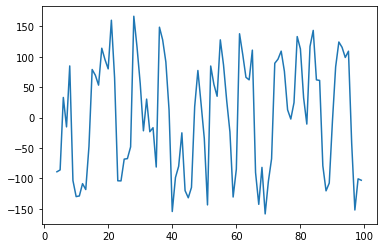

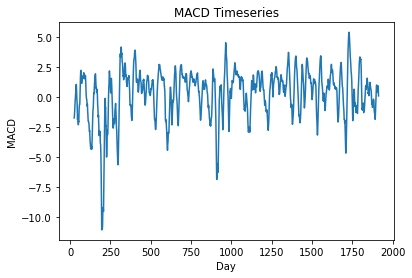

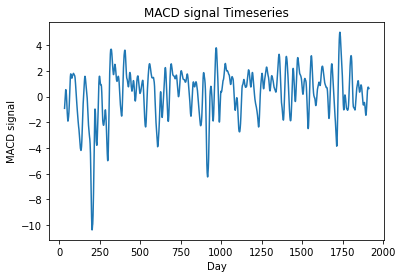

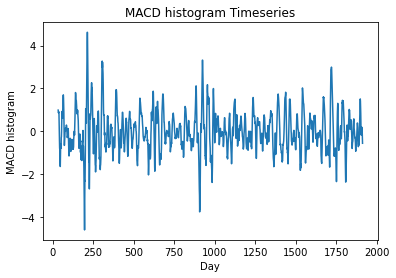

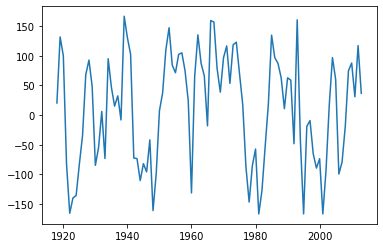

In [7]:
train1.plot_CCI()
train1.plot_macd()
train1.plot_signal()
train1.plot_macd_hist()
val1.plot_CCI()

# Part3 Model & Training 

1. Build model
2. Define parameters 
3. Train model 

In [8]:
class StockModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.padding=nn.ZeroPad2d(1)
        self.conv1=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3),
            nn.ReLU()
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(3, 2)),
            nn.ReLU()
        )
        
        self.linear=nn.Linear(32*8*2,2)
        
        self.act=nn.Softmax()
        
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
        
        
    def forward(self,x):
#         print(x.size())
        out=self.padding(x)
        out=self.conv1(out)
        out=self.conv2(out)
#         print(out.size())
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        out=self.act(out) 
#         print(out.size())
        return out

In [57]:
#PyTorch model 0

class Net0(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size = 2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(nn.Linear(32*9*2,2))
        
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        #print('sizex1: ',x.size())
        x = self.modle(x)
        #print('sizex2: ',x.size())
        x = x.view(x.size(0), -1)
        #print('sizex3: ',x.size())
        x = self.fc(x)
        #print('sizex4: ',x.size())
        return x

In [ ]:
#PyTorch model 0

class Net0(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.ReLU(),
            #MaxPool2d(kernel_size = 2 , stride =2),
            nn.Conv2d(16,32,kernel_size = 2),
            nn.ReLU(),
            #nn.Dropout2d(0.3),
            #nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.fc = nn.Sequential(nn.Linear(32*9*2,2))
        
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        #print('sizex1: ',x.size())
        x = self.modle(x)
        #print('sizex2: ',x.size())
        x = x.view(x.size(0), -1)
        #print('sizex3: ',x.size())
        x = self.fc(x)
        #print('sizex4: ',x.size())
        return x

In [67]:
class Net0_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.padding=nn.ZeroPad2d(1)
        self.conv1=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3),
            nn.ReLU()
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(3, 2)),
            nn.ReLU()
        )
        
        self.linear=nn.Linear(32*8*2,2)
        self.act=nn.Softmax()
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
        
        
    def forward(self,x):
#         print(x.size())
        out=self.padding(x)
        out=self.conv1(out)
        out=self.conv2(out)
#         print(out.size())
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        out=self.act(out) 
#         print(out.size())
        return out

In [69]:
#PyTorch model 1

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),

            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.3),
           
        )
        self.fc = nn.Sequential(nn.Linear(32*9*2,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        #print('sizex1: ',x.size())
        x = self.modle(x)
        #print('sizex2: ',x.size())
        x = x.view(x.size(0), -1)
        #print('sizex3: ',x.size())
        x = self.fc(x)
        #print('sizex4: ',x.size())
        return x

In [72]:
#PyTorch model 2

class Net2_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(1),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.3),
            #nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.fc = nn.Sequential(nn.Linear(64*8*1,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        #print('sizex1: ',x.size())
        x = self.modle(x)
        #print('sizex2: ',x.size())
        x = x.view(x.size(0), -1)
        #print('sizex3: ',x.size())
        x = self.fc(x)
        #print('sizex4: ',x.size())
        return x

In [180]:
#PyTorch model 2_1

class Net2_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(1),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.7),
        )
        self.fc = nn.Sequential(nn.Linear(64*8*1,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [170]:
#PyTorch model 2_2

class Net2_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(1),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.7),
        )
        self.fc = nn.Sequential(nn.Linear(64*8*1,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [171]:
#PyTorch model 2_3

class Net2_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(1),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.8),
        )
        self.fc = nn.Sequential(nn.Linear(64*8*1,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [230]:
#PyTorch model 3

class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(4),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.8),
        )
        self.fc = nn.Sequential(nn.Linear(128*13*6,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
#PyTorch model 3

class Net3_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(4),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.6),
        )
        self.fc = nn.Sequential(nn.Linear(128*13*6,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
class Net3_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(4),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.8),
        )
        self.fc = nn.Sequential(nn.Linear(128*13*6,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
class Net3_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(4),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.8),
        )
        self.fc = nn.Sequential(nn.Linear(128*13*6,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    # Defining the forward pass    
    def forward(self, x):
        
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [231]:
#PyTorch model 4

class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.modle = nn.Sequential(
            
            nn.ZeroPad2d(4),
            nn.Conv2d(3,16,kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            #MaxPool2d(kernel_size = 2 , stride =2),
            
            nn.Conv2d(16,32,kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32,64,kernel_size = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(128,256,kernel_size = 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Dropout2d(0.3),
        )
        self.fc = nn.Sequential(nn.Linear(256*12*5,2))
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
    
    # Defining the forward pass    
    def forward(self, x):
        x = self.modle(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [232]:
#2. Define Parameters
# call this model, and define the optimizer and the loss function for the model
import torch.optim as optim
epochs = 20
model = Net3()

#Optimizer 
#optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#Loss Function
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.BCEWithLogitsLoss()
#Check GPU 
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net3(
  (modle): Sequential(
    (0): ZeroPad2d(padding=(4, 4, 4, 4), value=0.0)
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.8, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=9984, out_features=2, bias=True)
  )
)


In [233]:
#3. Train model
import datetime
def train_model(model,loss_func,optimizer,epochs, train_loader,validation_loader):
    
    for epoch in range(epochs):
        model.train()
        total_train_acc=0
        total_train_loss=0
        #epoch_acc = 0 
        
        for images,labels in train_loader:
            
            outputs = model(images) #scores
            loss=loss_func(outputs, torch.flatten(labels.long()))
            total_train_loss+=loss.item()
            acc=cal_acc(outputs,labels)
            total_train_acc+=acc
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss=total_train_loss/len(train_loader)
        train_acc=total_train_acc/len(train_loader)
        model.eval() # we must add this line before test 
        val_loss,val_acc,_,_=validation(model,validation_loader,loss_func)
    
        model.history['train_accuracy'].append(train_acc)
        model.history['validation_accuracy'].append(val_acc)
        model.history['train_loss'].append(train_loss)
        model.history['validation_loss'].append(val_loss)

        print("Epoch: {}/{} @ {} ".format(epoch+1, epochs,str(datetime.datetime.now())),
                          "\n",
                          "Training Loss: {:.4f} - ".format(train_loss),
                          "Training Accuracy: {:.4f} - ".format(train_acc),
                          "Validation Loss: {:.4f} - ".format(val_loss),
                          "Validation Accuracy: {:.4f}".format(val_acc),
                         # "Accuracy: {:.4f}".format(epoch_acc/len(train_loader))
             )
        
    return model

In [234]:
train_model(model,loss_function,optimizer,epochs, train1_loader,val1_loader)

Epoch: 1/20 @ 2021-05-01 02:45:55.623624  
 Training Loss: 201.3987 -  Training Accuracy: 0.4959 -  Validation Loss: 0.7342 -  Validation Accuracy: 1.0034
Epoch: 2/20 @ 2021-05-01 02:45:56.927643  
 Training Loss: 0.7525 -  Training Accuracy: 0.5434 -  Validation Loss: 0.6903 -  Validation Accuracy: 1.1125
Epoch: 3/20 @ 2021-05-01 02:45:58.311048  
 Training Loss: 0.6948 -  Training Accuracy: 0.5452 -  Validation Loss: 0.6887 -  Validation Accuracy: 1.1125
Epoch: 4/20 @ 2021-05-01 02:45:59.663602  
 Training Loss: 0.6938 -  Training Accuracy: 0.5456 -  Validation Loss: 0.6890 -  Validation Accuracy: 1.1125
Epoch: 5/20 @ 2021-05-01 02:46:01.036732  
 Training Loss: 0.6919 -  Training Accuracy: 0.5459 -  Validation Loss: 0.6890 -  Validation Accuracy: 1.1125
Epoch: 6/20 @ 2021-05-01 02:46:02.298419  
 Training Loss: 0.6923 -  Training Accuracy: 0.5458 -  Validation Loss: 0.6889 -  Validation Accuracy: 1.1125
Epoch: 7/20 @ 2021-05-01 02:46:03.680811  
 Training Loss: 0.6924 -  Training Ac

Net3(
  (modle): Sequential(
    (0): ZeroPad2d(padding=(4, 4, 4, 4), value=0.0)
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.8, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=9984, out_features=2, bias=True)
  )
)

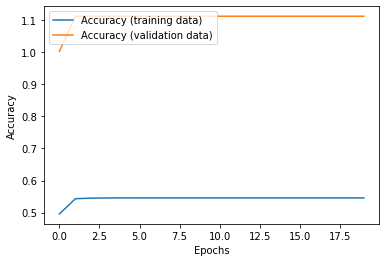

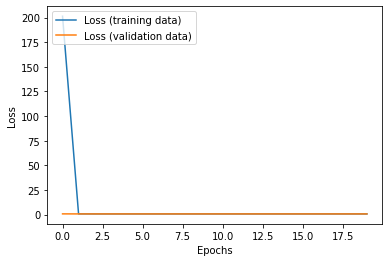

In [235]:
plot_accuracy(model)
plot_loss(model)

# Part4 Test 

In [236]:
# Test Set 
model.eval()
# test_loss,test_acc
test_loss,test_acc,outputs,labels=validation(model,test1_loader,loss_function)

print('test_loss: ',test_loss,'test_acc: ',test_acc)
#print('outputs:',outputs,'labels: ', labels)

test_loss:  0.7009437999555043 test_acc:  tensor(0.8616)


# Part5 Save and Load model 

test_loss:  0.7009437999555043 test_acc:  tensor(0.8616)
result[AUC]:  0.5
result[report]               precision    recall  f1-score   support

         0.0       0.44      1.00      0.62       193
         1.0       0.00      0.00      0.00       241

    accuracy                           0.44       434
   macro avg       0.22      0.50      0.31       434
weighted avg       0.20      0.44      0.27       434

-------------Dataframe------------
         Pred 0  Pred 1
Label 0     193       0
Label 1     241       0


/Users/chenyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chenyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chenyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


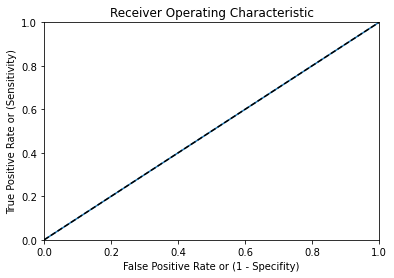

In [237]:
torch.save(model,"train_model3_3.pth")

load_model = torch.load("train_model3_3.pth")
test_loss,test_acc,outputs,labels= validation(load_model,test1_loader,loss_function)
print('test_loss: ',test_loss,'test_acc: ',test_acc)
result,fig=evaluate(torch.cat(labels),torch.cat(outputs))
print('result[AUC]: ', result['AUC'])
print('result[report]', result['report'])
print('-------------Dataframe------------')
df=pd.DataFrame(data = result['ConMatrix'],index=['Label 0','Label 1'],columns=['Pred 0','Pred 1'])
print(df)
